# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

# Importante
Para instalar LightFM si no la tiene, descomentar la siguiente linea de código.

In [1]:
#conda install -c conda-forge lightfm

## Librerías necesarias

In [2]:
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import lightfm
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from lightfm.evaluation import recall_at_k


sns.set()

C:\Users\Fabri\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


### Función para extraer los datos de los dataset comprimidos

In [4]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

### Importo el Dataset con las Reviews
Se extrajo la información del archivo con las reviews y se lo transformó en un Data Frame. Para la extracción de los datos, se omitió la columna con el texto de la review para poder obtener todos los datos sin saturar la RAM y tampoco se iba a utilizar en este caso.

In [5]:
data_reviews = []
for l in parse('steam_reviews.json.gz'):
    l.pop("text")
    data_reviews.append(l)

In [6]:
data_reviews = pd.DataFrame(data_reviews)

### Análisis rápido de los datos

Se realizó un análisis simple de los datos para empezar a conocer los datos con los que vamos a trabajar, como ser el tipo de dato, datos faltantes, duplicados, etc.

In [7]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,False,1,NaN,NaN,76561198007483075


In [8]:
print("Tamaño:", data_reviews.shape)

Tamaño: (7793069, 11)


In [9]:
data_reviews.drop(columns = ["page_order", "page", "found_funny"], inplace = True)

Las columnas "page_order" y "page" se eliminaron porque indicaban la ubicación de la review en la web y no es relevante ese dato. Por otro lado, la columna "found_funny" indica la cantidad de usuarios que encontraron divertida la review correspondiente, lo cual tampoco es relevante para el objetivo.

Se exportaron los datos obtenidos en un csv para omitir todos los pasos anteriores mientras se trabajaba.

In [10]:
#data_reviews.to_csv('steam_reviews_new.csv', index= False)

Se continuó con el análisis de los datos

In [11]:
data_reviews.dtypes

username         object
hours           float64
products        float64
product_id       object
date             object
early_access       bool
compensation     object
user_id          object
dtype: object

#### Cambio del tipo de dato en las columnas correspondientes

Se cambió el tipo de dato en la columna "date" para pasarla al tipo fecha (datetime).

In [12]:
data_reviews["date"] = pd.to_datetime(data_reviews["date"])

In [13]:
data_reviews.dtypes

username                object
hours                  float64
products               float64
product_id              object
date            datetime64[ns]
early_access              bool
compensation            object
user_id                 object
dtype: object

In [14]:
data_reviews.describe(include = "all", datetime_is_numeric = True).round(1)

,username,hours,products,product_id,date,early_access,compensation,user_id
count,7793069,7766532.0,7778108.0,7793069,7793069,7793069,145623,3176223
unique,2567538,NaN,NaN,15474,NaN,2,1,1485611
top,123,NaN,NaN,440,NaN,False,Product received for free,76561198011965365
freq,2045,NaN,NaN,183666,NaN,6719736,145623,1254
mean,NaN,111.8,236.5,NaN,2016-02-17 06:55:41.625105664,NaN,NaN,NaN
min,NaN,0.0,1.0,NaN,2010-10-15 00:00:00,NaN,NaN,NaN
25%,NaN,4.0,45.0,NaN,2015-02-28 00:00:00,NaN,NaN,NaN
50%,NaN,15.3,110.0,NaN,2016-05-01 00:00:00,NaN,NaN,NaN
75%,NaN,59.7,246.0,NaN,2017-04-11 00:00:00,NaN,NaN,NaN
max,NaN,42100.7,18188.0,NaN,2018-01-05 00:00:00,NaN,NaN,NaN


In [15]:
print("Cantidad de datos faltantes:\n", data_reviews.isna().sum(), sep = "")

Cantidad de datos faltantes:
username              0
hours             26537
products          14961
product_id            0
date                  0
early_access          0
compensation    7647446
user_id         4616846
dtype: int64


In [16]:
#¿Cuántos juegos tienen acceso anticipado?
early_games = data_reviews.groupby("product_id")["early_access"].sum()
len(early_games[early_games > 0])

2311

In [17]:
#¿Cuántos usuarios recibieron el juego de forma gratuita?
data_reviews.compensation.value_counts()

Product received for free    145623
Name: compensation, dtype: int64

#### Breve descripción de los datos:

* **Username:** Corresponde a Nick del usuario, hay 208 datos faltantes y 2567531 valores únicos.
* **Hours:** Son las horas jugadas al juego correspondiente a la review que dejó el usuario, hay 26537 datos faltantes y tiene valores muy extremos. El mínimo es 0, el máximo es 42100.7, la media es 111.8 y la std 392.9.
* **Products:** Es la cantidad de juegos que posee el usuario en la plataforma de Steam. Hay 14961 datos faltantes, y también hay una gran dispersión en los valores. El mínimo es 1, el máximo 18188, la media 236.5 y la std 485.8.
* **Product_id:** Es nro de identificación de cada juego en la plataforma Steam, no hay datos faltantes y tenemos 15474 juegos distintos.
* **Date:** Es la fecha correspondiente a la review. Tenemos datos desde 2010 hasta 2018 y no hay datos faltantes.
* **Early_access:** Indica si el juego estaba con acceso anticipado al momento de la reseña (aún se encontraba en desarrollo). Hay 1073333 reviews con acceso anticipado que corresponden a 2311 juegos.
* **Compensation:** Indica que el usuario recibió el juego de forma gratuita. Hay 145623 usuarios que recibieron el juego gratis (puede ser regalado por un amigo o Steam lo regaló por tiempo limitado).
* **User_id:** Es el nro que identifica la cuenta en Steam. Hay muchos datos faltantes (4616846) y 1485611 valores únicos, lo que corresponde a casi la mitad de los valores de "Username".

Lo primero que se hizo fue eliminar la instancias con datos faltantes en "hours" ya que es nuestro dato para saber si un usuario jugó a un juego y cuánto (para deducir si le gustó o no, ya que no tenemos el dato sobre si lo recomendó o no al juego en la reseña)

In [18]:
data_reviews.dropna(subset = ["hours"], inplace = True)

### Duplicados

Se revisó si hay datos duplicados

In [19]:
duplicados = data_reviews[data_reviews.duplicated()]

In [20]:
print("Cantidad de filas duplicadas:", duplicados.shape[0], "\nCantidad total de filas:", data_reviews.shape[0])

Cantidad de filas duplicadas: 830855 
Cantidad total de filas: 7766532


In [21]:
#Se eliminan los duplicados
data_reviews.drop_duplicates(inplace = True)

In [22]:
print("Tamaño:", data_reviews.shape)

Tamaño: (6935677, 8)


Según lo que nos comentó el profe, los datos se obtivieron a partir de diversos Scrapings. También se realizó un análisis más profundo para ver porqué habia datos duplicados y se vió que los duplicados aparecian al eliminar las columnas "page" y "page_order", lo cual indicó que al realizar distintos scrapings se registraron las mismas reviews pero ubicadas en distintas páginas o distintos órdenes.

In [23]:
del duplicados

Ahora se analizó más en detalle nuestro dataset. Primero se revisó la cantidad de horas de juego para cada usuario.

### Horas total de juego para cada usuario (username)

Text(0.5, 1.0, 'Cantidad de horas totales que jugó cada usuario (50 usuarios con más cantidad de horas)')

C:\Users\Fabri\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 3640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Fabri\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 3640 missing from current font.
  font.set_text(s, 0, flags=flags)


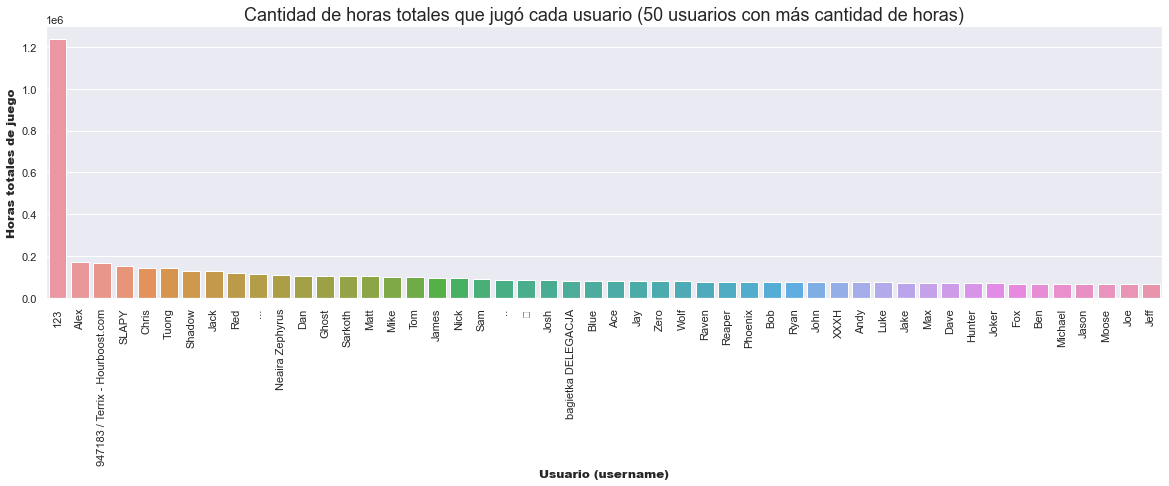

In [24]:
orden = data_reviews.groupby(["username"])['hours'].sum().reset_index().sort_values('hours', ascending=False)
orden.reset_index(drop = True, inplace = True)

plt.figure(figsize = (20,5))

sns.barplot(x = orden.username[0:50], y = orden.hours[0:50]) #, order = orden.username[0:50]
plt.xticks(rotation = 90)
plt.xlabel("Usuario (username)", fontweight = "black", fontsize = 12)
plt.ylabel("Horas totales de juego", fontweight = "black", fontsize = 12)
plt.title("Cantidad de horas totales que jugó cada usuario (50 usuarios con más cantidad de horas)", fontsize=18)

Analizamos más en detalle al jugador que aparece con más horas jugadas

In [25]:
jugador_123 = data_reviews[data_reviews.username == "123"]
jugador_123.shape

(1710, 8)

In [26]:
#¿Cuántos datos hay para cada juego?
juegos = pd.DataFrame()
juegos["Cantidad"] = jugador_123.product_id.value_counts()
juegos

,Cantidad
346110,423
252490,44
221100,26
440900,25
433850,23
...,...
230190,1
365360,1
473740,1
366220,1


In [27]:
#Selecciono los que más repeticiones tienen
lista_juegos = list(juegos[juegos.Cantidad >= 20].index)

In [28]:
jugador_123 = jugador_123[jugador_123.product_id.isin(lista_juegos)].copy()

Text(0.5, 1.0, 'Cantidad de horas jugadas en cada reseña (Usuario 123, 7 juegos con más cantidad de reseñas)')

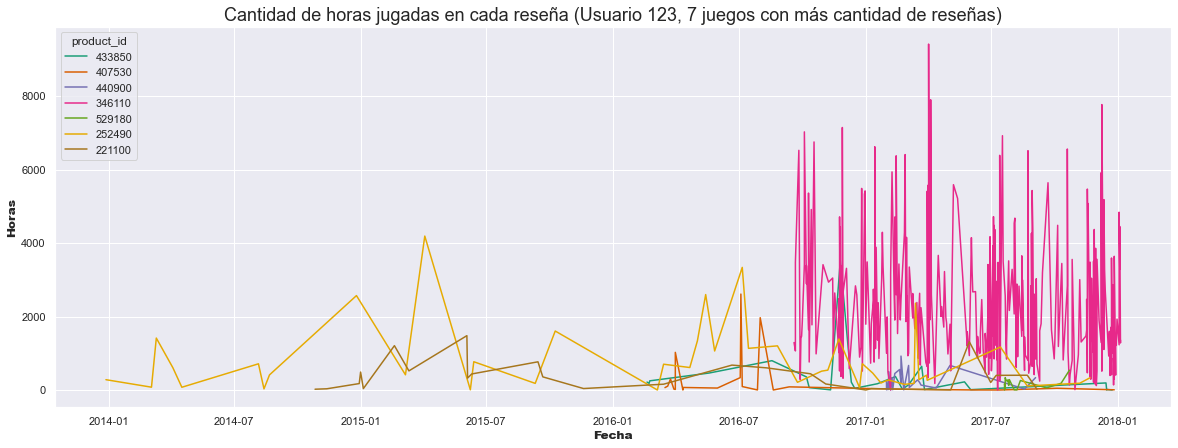

In [29]:
#Grafico la variación de las horas jugadas en el tiempo para cada juego
plt.figure(figsize = (20,7))

sns.lineplot(data=jugador_123, x='date', y='hours', hue='product_id', estimator = None, palette = "Dark2")
plt.xlabel("Fecha", fontweight = "black", fontsize = 12)
plt.ylabel("Horas", fontweight = "black", fontsize = 12)
plt.title("Cantidad de horas jugadas en cada reseña (Usuario 123, 7 juegos con más cantidad de reseñas)", fontsize=18)

Se supone que si el jugador dejó diversas reseñas sobre el mismo juego, las horas de juegos tienen que haber aumentado con el tiempo o a lo sumo mantenerse igual, pero en el gráfico se puede ver que esto no sucede. Esto se puede deber a que el username es algo que el jugador puede ir cambiando y debido a que los datos fueron obtenidos en diferentes fechas es posible que estos nombres se hayan modificado. Para tratar de solucionar este problema, vamos a analizar el "user_id" ya que se supone que ese dato es un número único para cada usuario.

Text(0.5, 1.0, 'Cantidad de horas totales que jugó cada usuario (50 usuarios con más cantidad de horas)')

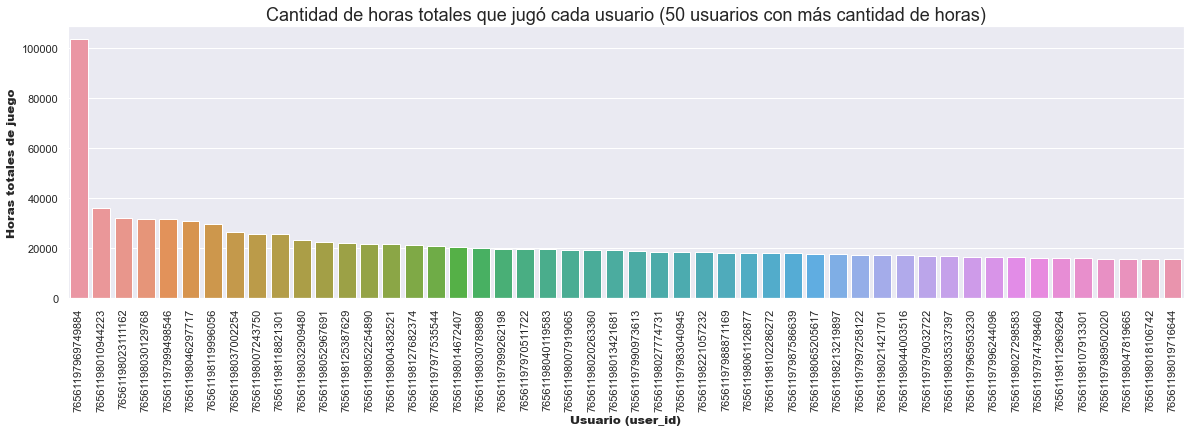

In [30]:
orden = data_reviews.groupby(["user_id"])['hours'].sum().reset_index().sort_values('hours', ascending=False)
orden.reset_index(drop = True, inplace = True)

plt.figure(figsize = (20,5))

sns.barplot(x = orden.user_id[0:50], y = orden.hours[0:50]) #, order = orden.user_id[0:50]
plt.xticks(rotation = 90)
plt.xlabel("Usuario (user_id)", fontweight = "black", fontsize = 12)
plt.ylabel("Horas totales de juego", fontweight = "black", fontsize = 12)
plt.title("Cantidad de horas totales que jugó cada usuario (50 usuarios con más cantidad de horas)", fontsize=18)

Al igual que antes, se analizó el jugador con más horas jugadas.

In [31]:
jugador = data_reviews[data_reviews.user_id == orden.user_id[0]]
jugador.shape

(730, 8)

In [32]:
juegos = jugador.product_id.value_counts().sort_values(ascending = False)
juegos

582550    1
269250    1
406130    1
94590     1
255320    1
         ..
237970    1
284850    1
284240    1
427820    1
23490     1
Name: product_id, Length: 730, dtype: int64

En este caso, solo se tiene un dato para cada juego jugado. 

Se buscó si habia usuarios con el mismo user_id con más de un dato para el mismo juego.

In [33]:
cantidad = data_reviews.groupby("user_id")["product_id"].value_counts().sort_values(ascending = False)
cantidad

user_id            product_id
76561198307560927  359550        2
76561198355001970  240           2
76561197994003201  270550        2
76561198079432538  433850        2
76561198201303919  434570        2
                                ..
76561198114304415  431960        1
                   265550        1
76561198114304403  377160        1
76561198114304185  353270        1
76561197960265806  105600        1
Name: product_id, Length: 2824799, dtype: int64

Se analizó la variación en la cantidad de horas jugadas para los casos con dos datos.

In [34]:
dobles = data_reviews.dropna(subset = ["user_id"]) #Eliminamos todas las instancias con valores faltantes en user_id
dobles = dobles[dobles.duplicated(subset=['user_id', "product_id"], keep = False)]
dobles.shape

(1254, 8)

In [35]:
dobles.sort_values(by = ['user_id','product_id','date','hours'], inplace = True) 
#Los ordenamos de forma tal que queden uno dejado del otro los datos correspondientes a mismo usuario y juego, primero el dato más antigüo y debajo el más reciente.

In [36]:
dobles['delta_hours'] = dobles.groupby(['user_id', 'product_id'])['hours'].diff() #Restamos la catidad de horas jugadas por el mismo usuario al mismo juego

In [37]:
dobles.head()

,username,hours,products,product_id,date,early_access,compensation,user_id,delta_hours
5163294,SKL,3.0,NaN,270880,2016-02-02,False,NaN,76561197960299730,NaN
5163454,SKL,3.0,161.0,270880,2016-02-02,False,NaN,76561197960299730,0.0
6537627,bill bonty,13.9,134.0,212680,2013-03-06,False,NaN,76561197961025317,NaN
6537643,Grospoliner,35.2,685.0,212680,2013-03-06,False,NaN,76561197961025317,21.3
1868589,Grospoliner,1.5,685.0,6980,2013-12-16,False,NaN,76561197961025317,NaN


In [38]:
#Buscamos si hay diferencias negativas
negativos = dobles[dobles.delta_hours < 0]
negativos

,username,hours,products,product_id,date,early_access,compensation,user_id,delta_hours
7143589,chrisaw,3.3,158.0,362890,2015-08-09,True,NaN,76561197969631885,-19.3
2423699,xTheTajemniczak,11.2,196.0,15100,2017-09-23,False,NaN,76561197970289054,-32.4
1988897,Actiniumer,2.3,147.0,443970,2016-10-15,False,NaN,76561197972162374,-12.2
2796782,DEUS VULT,47.5,233.0,8500,2014-03-07,False,NaN,76561197972466981,-384.1
5108455,Cat,2.6,30.0,287390,2017-06-29,False,NaN,76561197976057193,-6.8
...,...,...,...,...,...,...,...,...,...
2761661,JaysonTM,0.1,260.0,457330,2016-11-17,True,NaN,76561198272598758,-0.2
81224,ej,25.7,123.0,459820,2017-06-25,False,NaN,76561198273714575,-562.6
4209717,Irish Soflawlessknight97 (David),0.6,49.0,319510,2017-02-21,False,NaN,76561198273959661,-38.2
1603015,Butch,1.3,585.0,6880,2017-04-25,False,NaN,76561198333720963,-0.2


Se investigó más sobre el sistema de reseñas en Steam y se vió que sólo se puede dejar una reseña para el mismo juego, a lo sumo se puede editar, por lo cuál se pone más en duda la confiabilidad de estos datos dobles. Para evitar posibles datos erroneos, se eliminaron los datos duplicados para "user_id" y "product_id".

In [39]:
indices = dobles.index

Int64Index([5163294, 5163454, 6537627, 6537643, 1868589, 1868578, 5702522,
            5702753,  155088,  155347,
            ...
            3477204, 3477425, 3807382, 3807538, 1475060, 1475051, 7516171,
            7517481, 7464675, 7465007],
           dtype='int64', length=1254)

In [40]:
data_reviews.dropna(subset = ["user_id"], inplace = True) #Eliminamos los datos faltantes de user_id (antes se guardó en una copia)
print(data_reviews.shape)

(2825426, 8)


In [41]:
data_reviews.drop(index = indices, inplace = True) #eliminamos los datos dobles
print(data_reviews.shape)

(2824172, 8)


In [42]:
data_reviews.drop(columns = "username", inplace = True) #Eliminamos la columna username ya que vamos a trabajar con el user ID

In [43]:
data_reviews.reset_index(inplace = True, drop = True) #Reseteamos los indices

In [44]:
data_reviews.groupby("user_id")["product_id"].value_counts().sort_values(ascending = False) #Controlamos que se hayan eliminado correctamente los datos dobles

user_id            product_id
76561198803033786  105600        1
76561198041142474  578330        1
76561198041142749  33670         1
                   298050        1
                   289070        1
                                ..
76561198114317387  233740        1
76561198114317326  440           1
76561198114317083  274170        1
                   209160        1
76561197960265806  105600        1
Name: product_id, Length: 2824172, dtype: int64

In [45]:
del dobles
del negativos

### Date

¿Cuántos datos hay según el año?

Text(0.5, 1.0, 'Cantidad de datos por año')

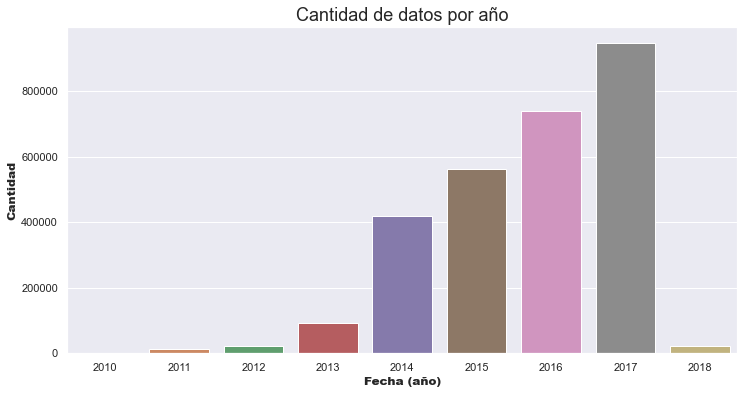

In [46]:
plt.figure(figsize = (12, 6))

sns.countplot(x = data_reviews["date"].dt.year)
plt.xlabel("Fecha (año)", fontweight = "black", fontsize = 12)
plt.ylabel("Cantidad", fontweight = "black", fontsize = 12)
plt.title("Cantidad de datos por año", fontsize=18)

Se ve un claro crecimiento en la cantidad de reviews con el paso de los años, a excepción del 2018 (probablemente los datos se hayan recolectado a principios de ese año). En el año 2014 el aumento es mucho más marcado.

### Productos

¿Hay una relación entre la cantidad de productos y la cantidad de horas jugadas? Por ejemplo, los usuarios con muchos juegos probablemente jueguen menos horas a cada uno y viceversa.

Text(0.5, 1.0, 'Relación entre la cantidad de productos y las horas jugadas')

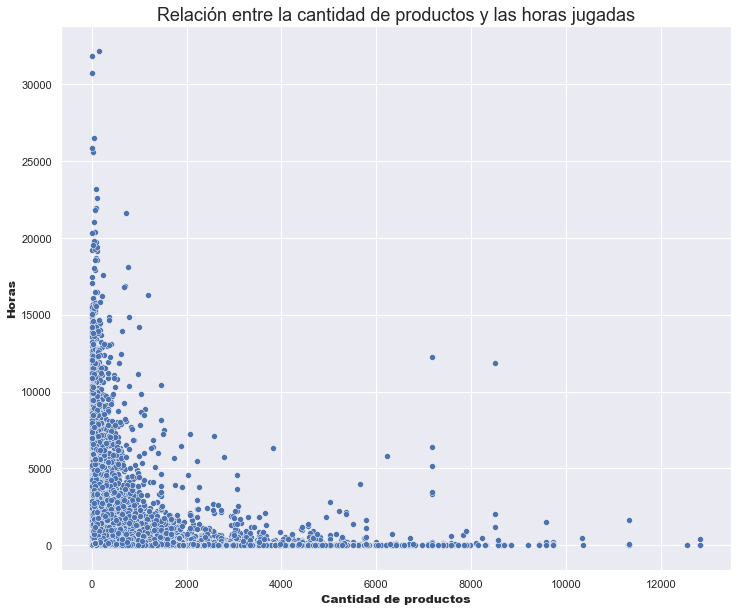

In [47]:
plt.figure(figsize = (12, 10))
sns.scatterplot(x = data_reviews["products"], y = data_reviews["hours"])
plt.xlabel("Cantidad de productos", fontweight = "black", fontsize = 12)
plt.ylabel("Horas", fontweight = "black", fontsize = 12)
plt.title("Relación entre la cantidad de productos y las horas jugadas", fontsize=18)

Se podría decir que los usuarios que juegan MUCHAS horas a un juego no tienen muchos productos (menos de 2000) y los usuarios que poseen MUCHOS productos no juegan muchas horas (menos de 10000). Pero por debajo de esos límites extremos no existe ninguna relación.

### Horas de juego

Volvemos a analizar las horas de juego, con los datos correctos.

**¿Cuántas horas de juego tienen los juegos más jugados?**

In [48]:
total_hours = data_reviews.groupby(["product_id"])['hours'].sum().sort_values(ascending=False)

Text(0.5, 1.0, 'Cantidad de horas totales que tienen los 50 juegos más jugados')

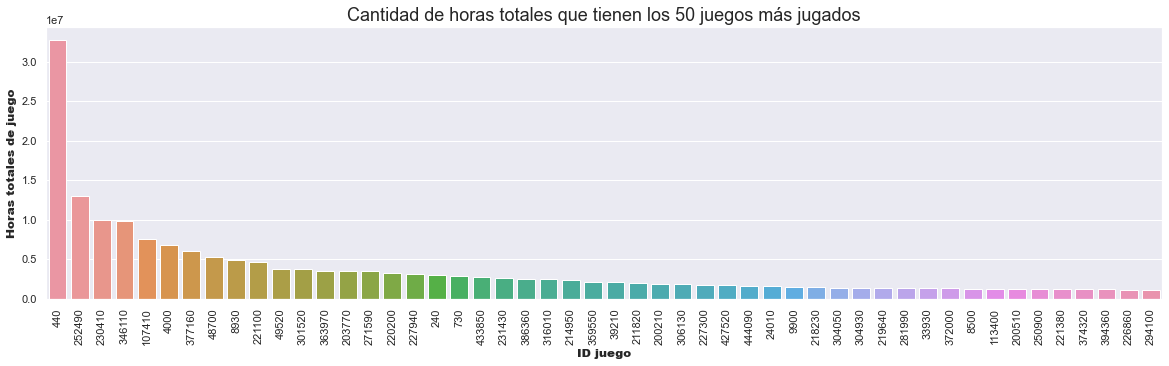

In [49]:
plt.figure(figsize = (20,5))

sns.barplot(x = total_hours.index[0:50], y = total_hours.values[0:50])
plt.xticks(rotation = 90)
plt.xlabel("ID juego", fontweight = "black", fontsize = 12)
plt.ylabel("Horas totales de juego", fontweight = "black", fontsize = 12)
plt.title("Cantidad de horas totales que tienen los 50 juegos más jugados", fontsize=18)

In [50]:
print("Juego con más horas acumuladas: ", total_hours.index[0], ", con " "%.1f" % total_hours[0], " horas", sep = "")

Juego con más horas acumuladas: 440, con 32763196.8 horas


**¿Cuántas horas jugadas tienen en promedio por jugador los juegos más jugados?**

In [51]:
mean_hours = data_reviews.groupby("product_id")["hours"].mean().sort_values(ascending = False)

Text(0.5, 1.0, 'Cantidad de horas promedio por jugador que tienen los 50 juegos más jugados')

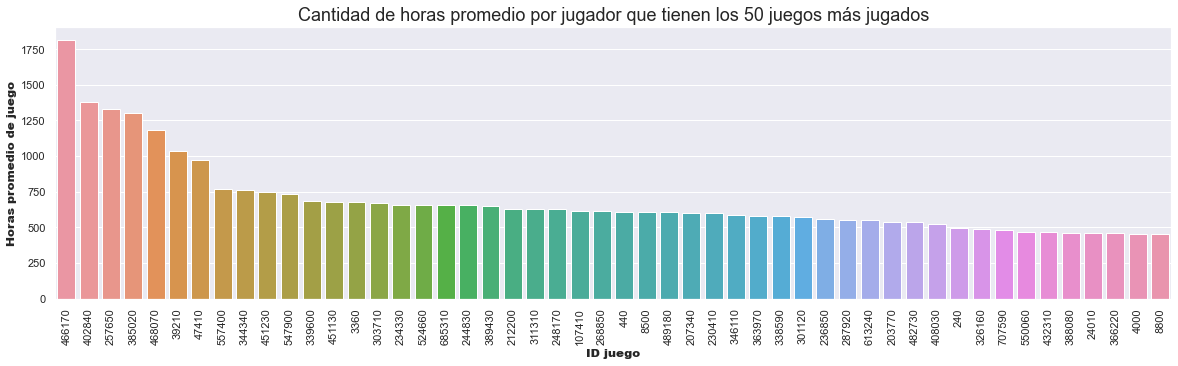

In [52]:
plt.figure(figsize = (20,5))

sns.barplot(x = mean_hours.index[0:50], y = mean_hours.values[0:50])
plt.xticks(rotation = 90)
plt.xlabel("ID juego", fontweight = "black", fontsize = 12)
plt.ylabel("Horas promedio de juego", fontweight = "black", fontsize = 12)
plt.title("Cantidad de horas promedio por jugador que tienen los 50 juegos más jugados", fontsize=18)

In [53]:
print("Juego con más horas promedio por usuario: ", mean_hours.index[0], ", con " "%.1f" % mean_hours[0], " horas", sep = "")

Juego con más horas promedio por usuario: 466170, con 1816.0 horas


**¿Cuántos jugadores tienen los juegos con más cantidad de usuarios?**

In [54]:
nro_users = data_reviews["product_id"].value_counts()

Text(0.5, 1.0, 'Cantidad de usuarios que tienen los 50 juegos más jugados')

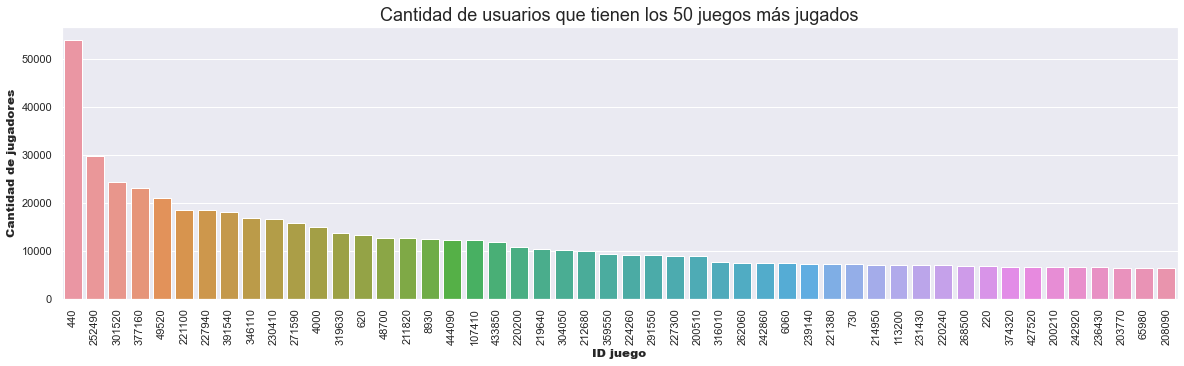

In [55]:
plt.figure(figsize = (20,5))

sns.barplot(x = nro_users.index[0:50], y = nro_users.values[0:50])
plt.xticks(rotation = 90)
plt.xlabel("ID juego", fontweight = "black", fontsize = 12)
plt.ylabel("Cantidad de jugadores", fontweight = "black", fontsize = 12)
plt.title("Cantidad de usuarios que tienen los 50 juegos más jugados", fontsize=18)

In [56]:
print("Juego con más cantidad de usuarios: ", nro_users.index[0], ", con ", nro_users[0], " usuarios", sep = "")

Juego con más cantidad de usuarios: 440, con 53962 usuarios


El juego 440 tenía la mayor cantidad de horas acumuladas de juego, pero luego al calcular las horas promedio por usuario se podía ver que había varios juegos con mayor cantidad de horas promedio por usuario que éste. Al ver la cantidad de usuarios vemos que el 440 posee una gran cantidad de usuarios, y eso es lo que llevó a la gran cantidad de horas totales de juego.

**¿Cuántas horas de juego totales tienen los jugadores que más juegan?**

In [57]:
horas_totales = data_reviews.groupby(["user_id"])['hours'].sum().sort_values(ascending=False)

Text(0.5, 1.0, 'Cantidad de horas jugadas que tienen los 50 jugadores que más juegan')

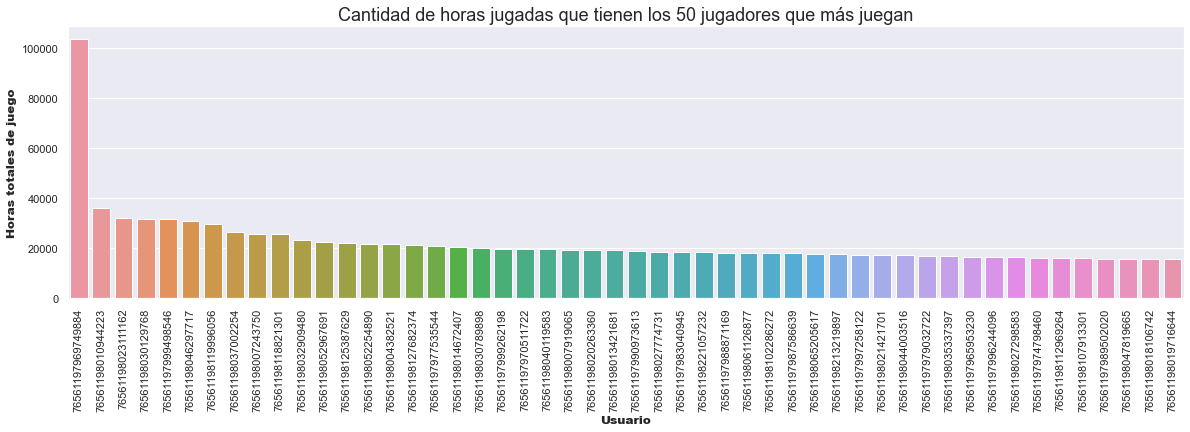

In [58]:
plt.figure(figsize = (20,5))

sns.barplot(x = horas_totales.index[0:50], y = horas_totales.values[0:50])
plt.xticks(rotation = 90)
plt.xlabel("Usuario", fontweight = "black", fontsize = 12)
plt.ylabel("Horas totales de juego", fontweight = "black", fontsize = 12)
plt.title("Cantidad de horas jugadas que tienen los 50 jugadores que más juegan", fontsize=18)

In [59]:
print("Usuario con más horas jugadas: ", horas_totales.index[0], ", con ", "%.1f" % horas_totales[0], " horas", sep = "")

Usuario con más horas jugadas: 76561197969749884, con 103648.8 horas


**¿Cuántas horas promedio de juego tienen los jugadores que más juegan?**

In [60]:
mean_hours = data_reviews.groupby("user_id")["hours"].mean().sort_values(ascending = False)

Text(0.5, 1.0, 'Cantidad de horas promedio jugadas que tienen los 50 usuarios que más juegan')

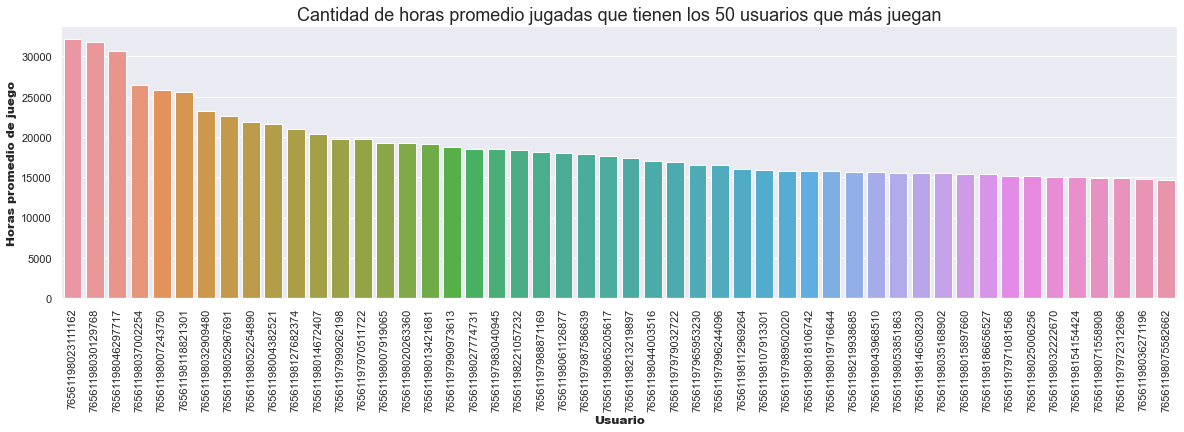

In [61]:
plt.figure(figsize = (20,5))

sns.barplot(x = mean_hours.index[0:50], y = mean_hours.values[0:50])
plt.xticks(rotation = 90)
plt.xlabel("Usuario", fontweight = "black", fontsize = 12)
plt.ylabel("Horas promedio de juego", fontweight = "black", fontsize = 12)
plt.title("Cantidad de horas promedio jugadas que tienen los 50 usuarios que más juegan", fontsize=18)

In [62]:
print("Usuario con más horas promedio jugadas: ", mean_hours.index[0], ", con ", "%.1f" % mean_hours[0], " horas", sep = "")

Usuario con más horas promedio jugadas: 76561198023111162, con 32146.1 horas


**¿Cuáles son los usuarios con más juegos jugados?**

In [63]:
nro_games = data_reviews["user_id"].value_counts()

Text(0.5, 1.0, 'Cantidad de juegos que jugaron los 50 usuarios que más juegan')

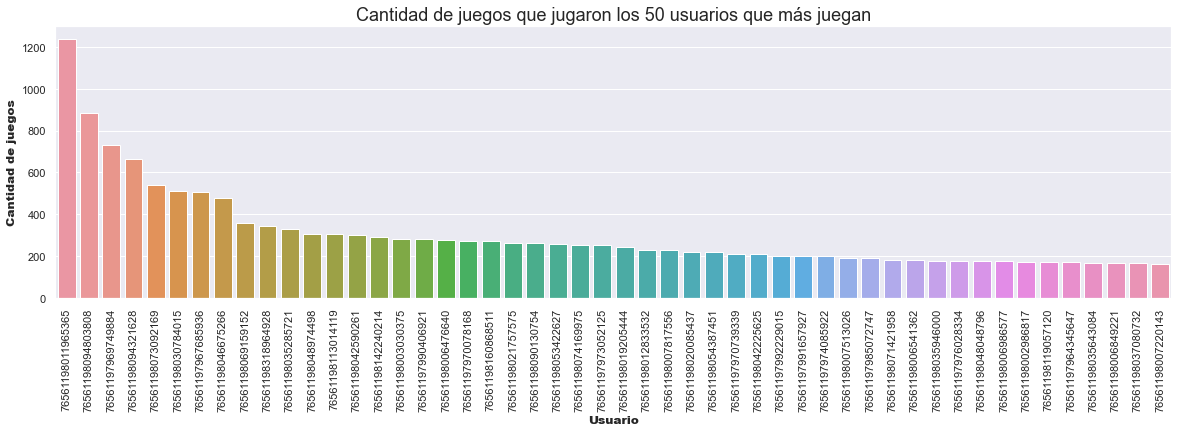

In [64]:
plt.figure(figsize = (20,5))

sns.barplot(x = nro_games.index[0:50], y = nro_games.values[0:50])
plt.xticks(rotation = 90)
plt.xlabel("Usuario", fontweight = "black", fontsize = 12)
plt.ylabel("Cantidad de juegos", fontweight = "black", fontsize = 12)
plt.title("Cantidad de juegos que jugaron los 50 usuarios que más juegan", fontsize=18)

In [65]:
print("Usuario con más juegos jugados: ", nro_games.index[0], ", con ", nro_games[0], " juegos", sep = "")

Usuario con más juegos jugados: 76561198011965365, con 1236 juegos


#### Resumen usuarios



In [66]:
user_1 = data_reviews[data_reviews.user_id == horas_totales.index[0]]
user_2 = data_reviews[data_reviews.user_id == mean_hours.index[0]]
user_3 = data_reviews[data_reviews.user_id == nro_games.index[0]]

In [67]:
print("Usuario con más horas en total jugadas: ", horas_totales.index[0], ", con ", "%.1f" % user_1.hours.sum(), " horas, y ", user_1.shape[0], " juegos jugados", sep = "")
print("Usuario con más horas promedio jugadas: ", mean_hours.index[0], ", con ", "%.1f" % user_2.hours.mean(), " horas, y ", user_2.shape[0], " juegos jugados", sep = "")
print("Usuario con más juegos jugados: ", nro_games.index[0], ", con ", user_3.shape[0], " juegos, y ", "%.1f" % user_3.hours.sum(), " horas en total jugadas", sep = "")

Usuario con más horas en total jugadas: 76561197969749884, con 103648.8 horas, y 730 juegos jugados
Usuario con más horas promedio jugadas: 76561198023111162, con 32146.1 horas, y 1 juegos jugados
Usuario con más juegos jugados: 76561198011965365, con 1236 juegos, y 12673.2 horas en total jugadas


### Filtrado y reducción del dataset
#### Horas

Ahora se analiza la distribución de la variable "hours" y se procede a realizar un filtrado y eliminación de valores extremos.

In [68]:
data_reviews.hours.describe().round(1)

count    2824172.0
mean         111.3
std          377.1
min            0.0
25%            4.3
50%           16.8
75%           64.9
max        32146.1
Name: hours, dtype: float64

Text(0.5, 1.0, 'Boxplot de la variable Horas')

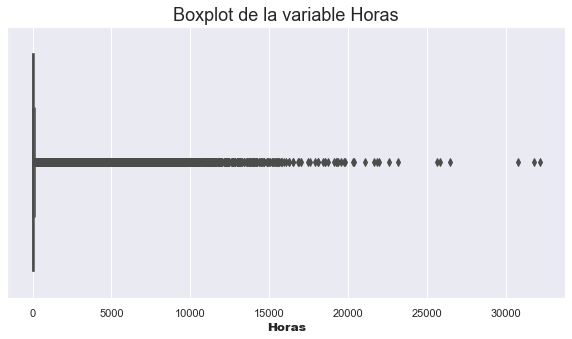

In [69]:
plt.figure(figsize = (10,5))
sns.boxplot(x = data_reviews.hours)
plt.xlabel("Horas", fontweight = "black", fontsize = 12)
plt.title("Boxplot de la variable Horas", fontsize=18)

(0.0, 5000.0)

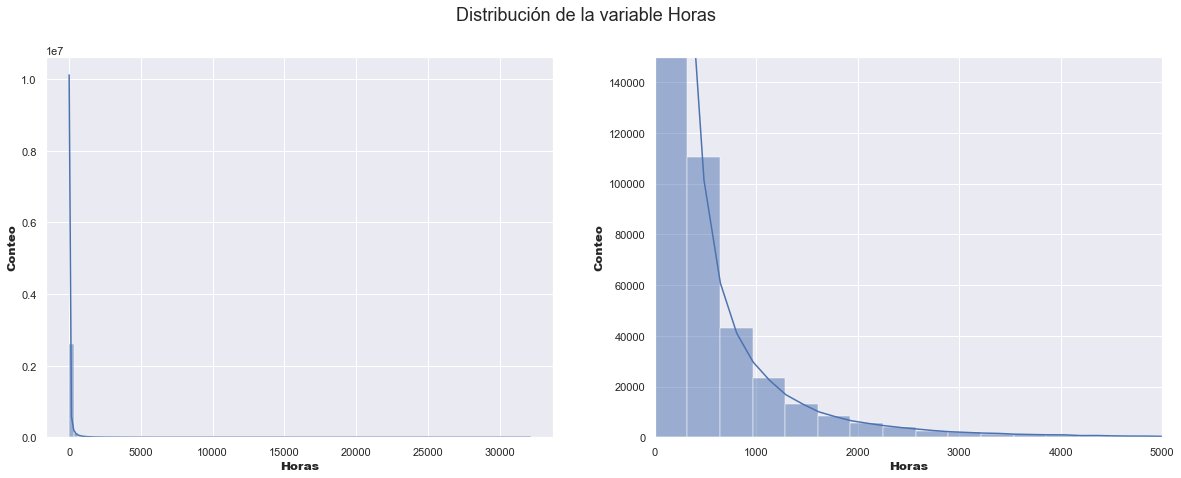

In [70]:
plt.figure(figsize = (20,7))
plt.suptitle("Distribución de la variable Horas", fontsize=18)
plt.subplot(1,2,1)
sns.histplot(data_reviews.hours, bins = 100, kde = True)
plt.xlabel("Horas", fontweight = "black", fontsize = 12)
plt.ylabel("Conteo", fontweight = "black", fontsize = 12)

plt.subplot(1,2,2)
sns.histplot(data_reviews.hours, bins = 100, kde = True)
plt.xlabel("Horas", fontweight = "black", fontsize = 12)
plt.ylabel("Conteo", fontweight = "black", fontsize = 12)
plt.ylim(0,150000)
plt.xlim(0,5000)

Nuestra variable "hours" tiene una distribución asimétrica positiva ("J" invertida), con una gran cola hacia la izquierda. 

En primer lugar, se definió un límite inferior igual a 5 horas de juego. Se estableció este valor para quedarnos con interacciones positivas, basándonos en la opción de Steam de poder pedir el reembolso de un juego teniendo menos de 2 horas de juego, a esto se le agregó 3 horas más para tener un poco más de seguridad de que realmente es una interacción positiva. Luego, como límite superior se estableció 3000 horas que es cuando empieza a acercarse a 0 el gráfico anterior y también se consideró una cantidad de horas razonable para eliminar los casos extremos.

In [71]:
seleccion = data_reviews[(5 <= data_reviews.hours) & (data_reviews.hours <= 3000)]

In [72]:
seleccion.hours.describe().round(1)

count    2050892.0
mean         134.0
std          298.0
min            5.0
25%           13.4
50%           32.9
75%          104.5
max         2999.9
Name: hours, dtype: float64

Text(0.5, 1.0, 'Boxplot de la variable Horas')

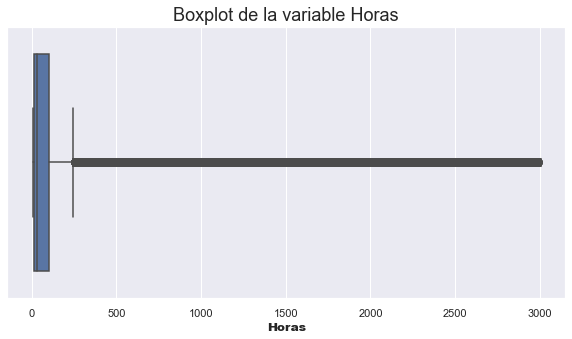

In [73]:
plt.figure(figsize = (10,5))
sns.boxplot(x = seleccion.hours)
plt.xlabel("Horas", fontweight = "black", fontsize = 12)
plt.title("Boxplot de la variable Horas", fontsize=18)

Text(0, 0.5, 'Conteo')

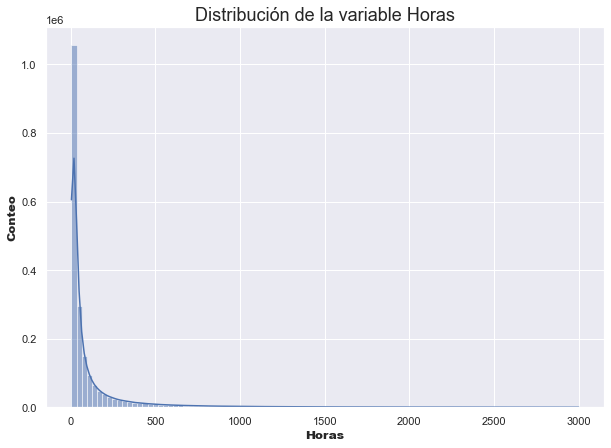

In [74]:
plt.figure(figsize = (10,7))
plt.title("Distribución de la variable Horas", fontsize=18)
sns.histplot(seleccion.hours, bins = 100, kde = True)
plt.xlabel("Horas", fontweight = "black", fontsize = 12)
plt.ylabel("Conteo", fontweight = "black", fontsize = 12)

In [75]:
del data_reviews

### Juegos y Usuarios

A continuación se analizan y filtran los juegos según la cantidad de usuarios que lo jugaron y los usuarios según la cantidad de juegos que jugaron

In [76]:
#Cantidad de usuarios que tienen cada juego
juegos = pd.DataFrame()
juegos["Cantidad"] = seleccion.product_id.value_counts()
juegos

,Cantidad
440,48822
252490,26848
377160,21894
301520,21831
49520,20057
...,...
593340,1
496850,1
690610,1
410130,1


¿Cuántos juegos fueron jugados por 1 o 2 usuarios nada más?

In [77]:
juegos[juegos.Cantidad < 3].value_counts()

Cantidad
1           1858
2           1056
dtype: int64

In [78]:
#Cantidad de juegos que jugó cada usuario
usuarios = pd.DataFrame()
usuarios["Cantidad_juegos"] = seleccion.user_id.value_counts()
usuarios

,Cantidad_juegos
76561197969749884,727
76561198011965365,597
76561198094803808,266
76561198003030375,215
76561198142240214,214
...,...
76561198002695886,1
76561198045032938,1
76561198168273443,1
76561198292824979,1


¿Cuántos usuarios jugaron 5 o menos juegos?

In [79]:
usuarios[usuarios.Cantidad_juegos <= 6].value_counts()

Cantidad_juegos
1                  877989
2                  176702
3                   65276
4                   31125
5                   17456
6                   10769
dtype: int64

Vamos a quedarnos con juegos que hayan sido jugados por más de dos personas, y usuarios que hayan jugado a más de 4 juegos. También vamos a eliminar los usuarios que jugaron a más de 300 juegos por considerarlos muy extremos y pueden meternos interacciones dudosas o que no aportan al modelo.

In [80]:
while (seleccion.product_id.value_counts() > 2).all() != True:
    #juegos = pd.DataFrame()
    juegos["Cantidad"] = seleccion.product_id.value_counts()
    lista_juegos = list(juegos[(juegos.Cantidad > 2)].index)
    seleccion = seleccion[seleccion.product_id.isin(lista_juegos)]
    
    #usuarios = pd.DataFrame()
    usuarios["Cantidad_juegos"] = seleccion.user_id.value_counts()
    lista_usuarios = list(usuarios[(usuarios.Cantidad_juegos > 4) & (usuarios.Cantidad_juegos <= 300)].index)
    seleccion = seleccion[seleccion.user_id.isin(lista_usuarios)]
    
seleccion.shape

(491823, 7)

## Dataset Juegos

Terminado el análisis y filtrado de las interacciones entre juegos y usuarios se importó el dataset con la información de los juegos y se realizó su respectivo análisis.

In [81]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [82]:
data_games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


In [83]:
print("Tamaño:", data_games.shape)

Tamaño: (32135, 16)


#### Cantidad de juegos sobre los que tengo datos de interacción

In [84]:
print("Cantidad de juegos:", seleccion["product_id"].unique().shape[0])

Cantidad de juegos: 6251


Como la cantidad de juegos que contiene el dataset "data_games" es mucho mayor a la cantidad de juegos cobre los que tengo interacción con usuarios, vamos a quedarnos solo con los juegos que comparten.

In [85]:
juegos = list(seleccion["product_id"].unique())
data_games = data_games[data_games.id.isin(juegos)]

In [86]:
data_games.shape

(6252, 16)

Después de hacer la selección se vió que la cantidad de juegos no coincide (data_games tiene un dato de más), así que se revisó la existencia de duplicados.

In [87]:
data_games[data_games.id.duplicated()]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
14573,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",NaN,http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games,Mostly Positive,86


In [88]:
data_games[data_games.id == "612880"]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
13894,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",NaN,http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games,Mostly Positive,86
14573,Bethesda Softworks,[Action],Wolfenstein II: The New Colossus,Wolfenstein II: The New Colossus,http://store.steampowered.com/app/612880/Wolfe...,2017-10-26,"[Action, FPS, Gore, Violent, Alternate History...",NaN,http://steamcommunity.com/app/612880/reviews/?...,"[Single-player, Steam Achievements, Full contr...",59.99,False,612880,Machine Games,Mostly Positive,86


Se encontró que la información de un juego está duplicada así que se eliminó una de las instancias.

In [89]:
data_games.drop(index = 13894, inplace = True)

In [90]:
#Reseteo los indices
data_games.reset_index(inplace = True, drop = True)

Antes de seguir ya podemos eliminar unas columnas que no nos interesan como la "url" y "reviews_url"

In [91]:
data_games.drop(columns = ["url", "reviews_url"], inplace = True)

### Análisis rápido de los datos

In [92]:
print("Cantidad de datos faltantes:\n", data_games.isna().sum(), sep = "")

Cantidad de datos faltantes:
publisher           66
genres              20
app_name             0
title                0
release_date         3
tags                 0
discount_price    6232
specs               39
price               63
early_access         0
id                   0
developer           50
sentiment            2
metascore         4080
dtype: int64


In [93]:
data_games.dtypes

publisher          object
genres             object
app_name           object
title              object
release_date       object
tags               object
discount_price    float64
specs              object
price              object
early_access         bool
id                 object
developer          object
sentiment          object
metascore          object
dtype: object

Se convirtió la columna "release_date" a Datetime

In [94]:
data_games["release_date"] = pd.to_datetime(data_games["release_date"])

In [95]:
#data_games["price"].astype(float, copy = False)
data_games["price"].unique()

array(['Free To Play', 9.99, 6.99, 'Free', 4.99, 19.99, 7.49, 14.99, 8.99,
       2.99, 12.99, 7.99, 2.49, 15.99, 5.99, nan, 0.99, 61.99, 29.99,
       39.99, 'Free to Play', 24.99, 11.99, 13.99, 3.99, 1.99,
       'Play for Free!', 74.76, 32.99, 99.99, 14.95, 59.99, 13.98, 34.99,
       16.99, 771.71, 'Install Now', 18.99, 49.99,
       'Play WARMACHINE: Tactics Demo', 10.99, 79.99, 0.98, 139.92,
       'Free Mod', 17.99, 0.89, 21.99, 44.99, 49.0,
       'Free HITMAN™ Holiday Pack', 69.99, 199.0, 26.99, 149.99, 15.0,
       20.99, 16.06, 4.68, 44.98, 202.76, 2.97, 19.95, 20.0, 6.48,
       'Play the Demo', 87.94, 0.49, 31.99, 12.89, 1.87, 1.0, 5.65, 12.0,
       23.99, 13.37, 189.96, 'Free Movie', 3.49, 59.95, 19.98, 160.91,
       'Free to Use', 4.49, 54.99], dtype=object)

La columna "price" no se puede convertir en float porque poseé como datos tanto números como textos.

In [96]:
data_games.describe(include = "all", datetime_is_numeric = True)

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
count,6185,6231,6251,6251,6248,6251,19.000000,6212,6188.00,6251,6251,6201,6249,2171.0
unique,2834,543,6251,6251,NaN,6010,NaN,1522,84.00,2,6251,4039,17,68.0
top,Ubisoft,[Action],BattleSpace,BattleSpace,NaN,"[Casual, Indie, Puzzle]",NaN,[Single-player],9.99,False,33600,Choice of Games,Very Positive,80.0
freq,96,439,1,1,NaN,12,NaN,678,1338.00,5842,1,27,2606,104.0
mean,NaN,NaN,NaN,NaN,2013-11-11 15:09:40.793850880,NaN,4.924211,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1988-05-01 00:00:00,NaN,0.490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,2012-12-12 00:00:00,NaN,0.490000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,2015-03-15 12:00:00,NaN,3.140000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2016-05-27 00:00:00,NaN,7.740000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,2018-02-08 00:00:00,NaN,19.990000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Breve descripción de los datos:

* **Publisher:** Nombre de la empresa que publicó y promociona el juego, hay 6 datos faltantes y 2835 valores únicos.
* **Genres:** Son los géneros correspondiente al juego, hay 20 datos faltantes.
* **App_name y Title:** Nombre del juego. No hay datos faltantes.
* **Release_date:** Fecha de lanzamiento del juego. Hay 3 datos faltantes y las fechas van desde 1988 hasta 2018.
* **Tags:** Similar a "genres", son las etiquetas con las que se identifica o clasifica al juego en Steam. No hay datos faltantes.
* **Discount_price:** Si está presente indica el precio de descuento que tiene el juego aplicado, hay 6234 datos faltantes que están representando a juegos sin descuento.
* **Specs:** Similar a "tags" y "genres" pero por lo que se vió hasta ahora indica más que nada la modalidad de juego y controles. Hay 39 datos faltantes.
* **Price:** Precio del juego. Tiene 63 datos faltantes.
* **Early_access:** Al igual que en el dataset de las reviews, indica si es un juego con acceso anticipado que aún se encuentra en desarrollo.
* **Id:** Código de identificación del juego, igual que en "data_reviews".
* **Developer:** Empresa que desarrollo el juego. Hay 50 datos faltantes y 4041 valores únicos.
* **Sentiment:** Es el sentimiento general de los usuarios hacia el juego, basado en las reviews recibidas. Tiene 2 datos faltantes y 17 valores únicos.
* **Metascore:** Es la puntuación que tiene el juego según una página externa llamada Metacritic. Tiene 4082 valores faltantes y 68 valores únicos.

La información sobre Metascore y Discount_price no nos interesa así que ya las eliminamos

In [97]:
data_games.drop(columns = ["metascore", "discount_price"], inplace =  True)

Como "app_name" y "title" supuestamente es la misma información se corroboró para poder eliminar una de estas columnas.

In [98]:
data_games[data_games.title != data_games.app_name]

,publisher,genres,app_name,title,release_date,tags,specs,price,early_access,id,developer,sentiment
28,Telltale Games,"[Action, Adventure]",Sam & Max 101: Culture Shock,Sam &amp; Max 101: Culture Shock,2006-10-17,"[Point & Click, Comedy, Adventure, Detective, ...",[Single-player],19.99,False,8200,Telltale Games,Very Positive
51,Electronic Arts,[Strategy],Command & Conquer: Red Alert 3,Command &amp; Conquer: Red Alert 3,2008-10-28,"[Strategy, RTS, Base Building, Multiplayer, Co...",[Single-player],19.99,False,17480,EA Los Angeles,Very Positive
99,Ubisoft,[Strategy],Heroes of Might & Magic V: Hammers of Fate,Heroes of Might &amp; Magic V: Hammers of Fate,2006-11-14,"[Strategy, Turn-Based Strategy, Turn-Based, Fa...",[Single-player],9.99,False,15380,Nival,Mostly Positive
101,Ubisoft,[Strategy],Heroes of Might & Magic V: Tribes of the East,Heroes of Might &amp; Magic V: Tribes of the East,2007-10-16,"[Strategy, Turn-Based Strategy, Turn-Based, Fa...",[Single-player],9.99,False,15370,Nival,Very Positive
192,Electronic Arts,[Strategy],Command & Conquer: Red Alert 3 - Uprising,Command &amp; Conquer: Red Alert 3 - Uprising,2009-03-12,"[Strategy, RTS, Base Building, Singleplayer, M...",[Single-player],19.99,False,24800,EA Los Angeles,Very Positive
...,...,...,...,...,...,...,...,...,...,...,...,...
6129,Ubisoft,[Strategy],Heroes of Might & Magic V,Heroes of Might &amp; Magic V,2006-05-23,"[Strategy, Turn-Based Strategy, Fantasy, Tacti...",[Single-player],9.99,False,15170,Nival,Very Positive
6132,Telltale Games,[Adventure],Sam & Max 201: Ice Station Santa,Sam &amp; Max 201: Ice Station Santa,2007-11-09,[Adventure],[Single-player],19.99,False,8260,Telltale Games,Very Positive
6167,Telltale Games,"[Action, Adventure]",Sam & Max 104: Abe Lincoln Must Die!,Sam &amp; Max 104: Abe Lincoln Must Die!,2007-02-22,"[Adventure, Action, Point & Click, Free to Pla...",[Single-player],19.99,False,8230,Telltale Games,8 user reviews
6189,Strategy First,"[Action, Strategy]",Making History: The Calm & the Storm,Making History: The Calm &amp; the Storm,2007-03-13,"[Strategy, Action, Turn-Based Strategy, Grand ...","[Single-player, Multi-player]",4.99,False,6250,Muzzy Lane,Very Positive


Las diferencias entre "app_name" y "title" consisten en que este último tiene un error en la escritura del carácter &, por lo cual se eliminó "title" y se utilizó la variable "app_name".

In [99]:
data_games.drop(columns = "title", inplace = True)

A continuación se analizan en más detalle el resto de las variables.

#### Early access

In [100]:
data_games[data_games.early_access == True]

,publisher,genres,app_name,release_date,tags,specs,price,early_access,id,developer,sentiment
438,Serious Brothers,"[Indie, Simulation, Strategy, Early Access]",Imagine Earth,2014-05-20,"[Early Access, Strategy, Simulation, City Buil...","[Single-player, Steam Achievements, Steam Trad...",19.99,True,280720,Serious Brothers,Very Positive
612,NaN,"[Action, Adventure, Indie, RPG, Early Access]",Delver,2013-09-06,"[Early Access, Rogue-like, Indie, RPG, Dungeon...","[Single-player, Includes level editor]",7.99,True,249630,Priority Interrupt,Very Positive
634,Poppermost Productions,"[Free to Play, Indie, Simulation, Sports, Earl...",SNOW,2013-10-10,"[Early Access, Sports, Free to Play, Multiplay...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,True,244930,Poppermost Productions,Mostly Positive
672,The Indie Stone,"[Indie, RPG, Simulation, Early Access]",Project Zomboid,2013-11-08,"[Early Access, Survival, Zombies, Open World, ...","[Single-player, Multi-player, Co-op, Shared/Sp...",14.99,True,108600,The Indie Stone,Very Positive
677,NaN,"[Action, Adventure, Indie, RPG, Early Access]",Vox,2013-11-12,"[Early Access, RPG, Indie, Adventure, Action, ...","[Single-player, Multi-player, Co-op, Full cont...",9.99,True,252770,NaN,Mostly Negative
...,...,...,...,...,...,...,...,...,...,...,...
5310,Bohemia Interactive,"[Action, Indie, Massively Multiplayer, Early A...",DayZ,2013-12-16,"[Early Access, Survival, Zombies, Open World, ...","[Multi-player, Steam Cloud, Valve Anti-Cheat e...",34.99,True,221100,Bohemia Interactive,Mixed
5314,Facepunch Studios,"[Action, Adventure, Indie, Massively Multiplay...",Rust,2013-12-11,"[Early Access, Survival, Crafting, Multiplayer...","[Multi-player, MMO, Cross-Platform Multiplayer...",19.99,True,252490,Facepunch Studios,Very Positive
5436,Matthew C Cohen,"[Action, Adventure, Indie, Simulation, Early A...",Paranormal,2012-10-19,"[Early Access, Horror, Indie, Adventure, Simul...","[Single-player, Steam Trading Cards, Partial C...",9.99,True,246300,NaN,Mixed
5466,Zero Point Software,"[Action, Indie, RPG, Simulation, Early Access]",Interstellar Marines,2013-07-02,"[Early Access, Action, FPS, Indie, Tactical, C...","[Single-player, Multi-player, Co-op, Cross-Pla...",9.99,True,236370,Zero Point Software,Mixed


Hay un tag que indica si es Early access, así que se puede eliminar. Al igual que el precio, si es Free to Play hay un tag que lo indica.

In [101]:
data_games.drop(columns = ["early_access", "price"], inplace = True)

#### Tags y Genres

Se revisó si la información en "genres" está contenida también en "tags". (Recordemos que "genres posee datos faltantes mientras que "tags" no).

In [102]:
count = 0
indices = []
#Por cada juego se obtiene la info de "genres" y "tags", se comparan los elementos que tienen en común y luego estos se comparan con los elementos de "genres".
    #Si son iguales significa que esos géneros ya están en "tags" y se puede eliminar "genres". 
for i in data_games.index:
    if type(data_games.genres[i]) != float: #los NaN son tipo float
        gen = set(data_games.genres[i])
        tag = set(data_games.tags[i])
        gen_tag = gen.intersection(tag)
    
        if gen_tag != gen:
            count = count + 1
        
            indices.append(i)
        
print("Cantidad de juegos en los que 'genres' es distinto a 'tags':", count)

Cantidad de juegos en los que 'genres' es distinto a 'tags': 75


In [103]:
difference = []
for i in indices:
    gen = set(data_games.genres[i])
    tag = set(data_games.tags[i])
    gen_tag = gen.intersection(tag)
    dif = gen.difference(gen_tag)
    
    difference = difference + list(dif)
    
print(set(difference))

{'Animation &amp; Modeling', 'Massively Multiplayer', 'RPG', 'Strategy', 'Simulation', 'Indie', 'Casual', 'Adventure', 'Action', 'Free to Play', 'Design &amp; Illustration'}


Vamos a eliminar de los géneros "Animation '&amp'; Modeling" y "Design '&amp'; Illustration" ya que corresponden a los Tags "Animation & Modeling" y "Design & Illustration"

In [104]:
for i in indices:
    for element in data_games.genres[i]:
        if element == "Animation &amp; Modeling":
            data_games.genres[i].remove(element)
        
for i in indices:
    for element in data_games.genres[i]:
        if element == "Design &amp; Illustration":
            data_games.genres[i].remove(element)        

Ahora se combinaron los elementos de "genres" y "tags" para solucionar las diferencias que quedan.

In [105]:
data_games["tags_genres"] = data_games["genres"] + data_games["tags"]

for i in data_games.index:
    if type(data_games.genres[i]) != float:
        data_games.tags_genres[i] = list(set(data_games.tags_genres[i]))
    else:
        data_games.tags_genres[i] = data_games.tags[i]

<ipython-input-105-eb60d6aa9e42>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_games.tags_genres[i] = list(set(data_games.tags_genres[i]))
<ipython-input-105-eb60d6aa9e42>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_games.tags_genres[i] = data_games.tags[i]


In [106]:
data_games.head()

,publisher,genres,app_name,release_date,tags,specs,id,developer,sentiment,tags_genres
0,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",643980,Secret Level SRL,Mostly Positive,"[Female Protagonist, RPG, Strategy, Character ..."
1,Stainless Games Ltd,"[Action, Indie, Racing]",Carmageddon Max Pack,1997-06-30,"[Racing, Action, Classic, Indie, Gore, 1990's,...","[Single-player, Multi-player, Steam Trading Ca...",282010,Stainless Games Ltd,Very Positive,"[Classic, Multiplayer, Indie, 1990's, Singlepl..."
2,Valve,[Action],Half-Life,1998-11-08,"[FPS, Classic, Action, Sci-fi, Singleplayer, S...","[Single-player, Multi-player, Valve Anti-Cheat...",70,Valve,Overwhelmingly Positive,"[Classic, Shooter, Sci-fi, Retro, Adventure, S..."
3,Strategy First,[Strategy],Disciples II: Gallean's Return,2006-07-06,"[Turn-Based Strategy, Strategy, Classic, Atmos...","[Single-player, Multi-player, Co-op]",1640,Strategy First,Mostly Positive,"[Classic, Turn-Based, Isometric, Dark Fantasy,..."
4,Strategy First,[Strategy],Disciples II: Rise of the Elves,2006-07-06,"[Strategy, Turn-Based Strategy, Fantasy, Turn-...","[Single-player, Multi-player, Co-op]",1630,Strategy First,Very Positive,"[Classic, Turn-Based, Dark Fantasy, Atmospheri..."


Se corroboró que esté todo bien

In [107]:
print(data_games.genres[28])
print(data_games.tags[28])
print(data_games.tags_genres[28])

['Action', 'Adventure']
['Point & Click', 'Comedy', 'Adventure', 'Detective', 'Mystery', 'Episodic', 'Funny']
['Episodic', 'Mystery', 'Funny', 'Comedy', 'Point & Click', 'Adventure', 'Action', 'Detective']


In [108]:
print(data_games.genres[143])
print(data_games.tags[143])
print(data_games.tags_genres[143])

nan
['Horror', 'Lovecraftian', 'Survival Horror', 'First-Person', 'Based On A Novel', 'FPS', 'Adventure', 'Atmospheric', 'Stealth', 'Singleplayer', 'Story Rich', 'Action', 'Classic', 'Survival', 'Shooter', 'Difficult', 'Gore', 'Dark']
['Horror', 'Lovecraftian', 'Survival Horror', 'First-Person', 'Based On A Novel', 'FPS', 'Adventure', 'Atmospheric', 'Stealth', 'Singleplayer', 'Story Rich', 'Action', 'Classic', 'Survival', 'Shooter', 'Difficult', 'Gore', 'Dark']


Y se eliminaron las columnas "tags" y "genres"

In [109]:
data_games.drop(columns = ["tags", "genres"], inplace = True)

#### Date

En cuanto a la fecha de lanzamientos vamos a quedarnos solo con el año.

In [110]:
data_games["release_date"] = data_games.release_date[data_games["release_date"].notna()].dt.year.astype("Int64", errors = "ignore")

In [111]:
data_games.head(3)

,publisher,app_name,release_date,specs,id,developer,sentiment,tags_genres
0,"Making Fun, Inc.",Ironbound,2018,"[Single-player, Multi-player, Online Multi-Pla...",643980,Secret Level SRL,Mostly Positive,"[Female Protagonist, RPG, Strategy, Character ..."
1,Stainless Games Ltd,Carmageddon Max Pack,1997,"[Single-player, Multi-player, Steam Trading Ca...",282010,Stainless Games Ltd,Very Positive,"[Classic, Multiplayer, Indie, 1990's, Singlepl..."
2,Valve,Half-Life,1998,"[Single-player, Multi-player, Valve Anti-Cheat...",70,Valve,Overwhelmingly Positive,"[Classic, Shooter, Sci-fi, Retro, Adventure, S..."


Text(0, 0.5, 'Cantidad')

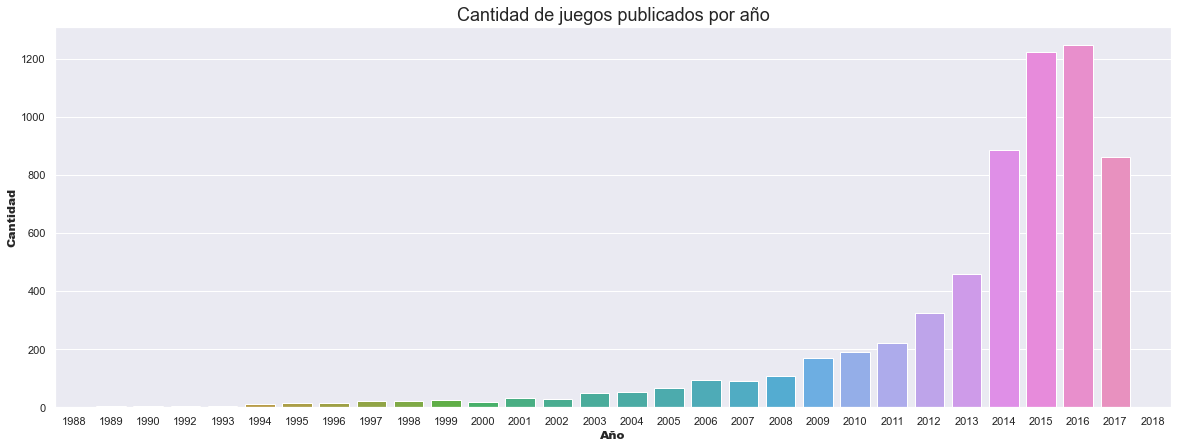

In [112]:
plt.figure(figsize = (20,7))
sns.countplot(x = "release_date", data = data_games[data_games["release_date"].notna()])
plt.title("Cantidad de juegos publicados por año", fontsize=18)
plt.xlabel("Año", fontweight = "black", fontsize = 12)
plt.ylabel("Cantidad", fontweight = "black", fontsize = 12)

Se ve un claro crecimiento en la cantidad de juegos publicados con el paso de los años, a excepción del 2018 (probablemente los datos se hayan recolectado a principios de ese año).

#### Sentiment

Se analizó en más detalle el sentimiento general de los juegos.

In [113]:
print(data_games.sentiment.value_counts())

Very Positive              2606
Mixed                      1489
Mostly Positive            1274
Positive                    373
Overwhelmingly Positive     268
Mostly Negative             160
Very Negative                14
8 user reviews               12
7 user reviews               10
9 user reviews               10
6 user reviews               10
4 user reviews                6
Overwhelmingly Negative       5
2 user reviews                4
5 user reviews                3
Negative                      3
1 user reviews                2
Name: sentiment, dtype: int64


Se reemplazaron los datos de "1-9 user reviews" y los faltantes por "Unknown".

In [114]:
data_games["sentiment"].replace(to_replace = ["1 user reviews", "2 user reviews", "3 user reviews", "4 user reviews", "5 user reviews", "6 user reviews", "7 user reviews", "8 user reviews", "9 user reviews"], 
                                value = "Unknown", inplace = True)

In [115]:
data_games["sentiment"].fillna("Unknown", inplace = True)

Text(0, 0.5, 'Cantidad')

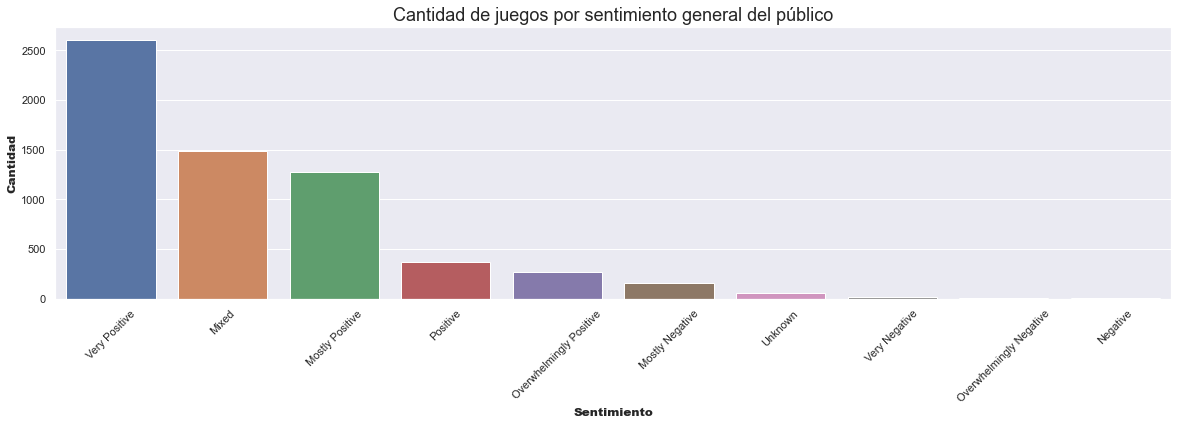

In [116]:
plt.figure(figsize = (20,5))
plt.xticks(rotation = 45)
sns.countplot(x = "sentiment", data = data_games, order = data_games["sentiment"].value_counts().index)
plt.title("Cantidad de juegos por sentimiento general del público", fontsize=18)
plt.xlabel("Sentimiento", fontweight = "black", fontsize = 12)
plt.ylabel("Cantidad", fontweight = "black", fontsize = 12)

La mayoría de los juegos tienen una recepción positiva o mixta.

En cuanto a las columnas que faltan ("specs", "developer" y "publisher") tienen más datos faltantes así que se omitieron.

Se unieron los dos datasets para tener la información de cada juego junto con las interacciones, sobre todo el nombre del juego. También se eliminaron las columnas que no vamos a utilizar para los modelos.

In [117]:
all_data = seleccion.merge(data_games, left_on = "product_id", right_on = "id")
all_data.drop(columns = ["products", "date", "early_access", "compensation", "publisher", "release_date", "specs", "developer", "sentiment", "id"], inplace = True)
all_data.head(3)

,hours,product_id,user_id,app_name,tags_genres
0,14.8,35140,76561198023491401,Batman: Arkham Asylum Game of the Year Edition,"[Batman, Adventure, Story Rich, Puzzle, Fighti..."
1,8.2,35140,76561198353396844,Batman: Arkham Asylum Game of the Year Edition,"[Batman, Adventure, Story Rich, Puzzle, Fighti..."
2,9.5,35140,76561198292325099,Batman: Arkham Asylum Game of the Year Edition,"[Batman, Adventure, Story Rich, Puzzle, Fighti..."


In [118]:
del data_games
del seleccion

## Matrices
### Matriz de interacciones
Se creó la matriz de interacciones asignando el valor 1 y tomando todas como interacciones positivas.

In [120]:
all_data["play"] = 1

In [ ]:
interacciones_matriz = pd.pivot_table(all_data, index='user_id', columns='app_name', values='play')
interacciones_matriz = interacciones_matriz.fillna(0)
#Se convirtió en una matriz coo
interacciones_matriz_coo = coo_matrix(interacciones_matriz.values)
interacciones_matriz_coo

### Matriz items-features
Matriz con las características de cada juego, se utilizaron los tags obtenidos antes.

In [122]:
games_explode = all_data.explode('tags_genres')

In [123]:
games_explode["value"] = 1

In [124]:
games_matrix = pd.pivot_table(games_explode, index='app_name', columns='tags_genres', values="value")
games_matrix = games_matrix.fillna(0)
#Se convirtió en una matriz csr
games_matrix = csr_matrix(games_matrix.values)
games_matrix

<6251x336 sparse matrix of type '<class 'numpy.float64'>'
	with 67400 stored elements in Compressed Sparse Row format>

## Train-Test split
Se dividió la matriz con las interacciones en Train y Test (25%).

In [126]:
train, test = random_train_test_split(interacciones_matriz_coo, test_percentage = 0.25, random_state = np.random.RandomState(42))

También se crearon unos diccionarios con los juegos que quedaron en cada conjunto para cada usuario.

In [127]:
test_matrix = pd.DataFrame.sparse.from_spmatrix(test, index = interacciones_matriz.index, columns = interacciones_matriz.columns)
train_matrix = pd.DataFrame.sparse.from_spmatrix(train, index = interacciones_matriz.index, columns = interacciones_matriz.columns)

test_matrix_t = test_matrix.transpose()
train_matrix_t = train_matrix.transpose()

In [128]:
jugados_train = {}
for i in train_matrix_t.columns:
    juegos = list(train_matrix_t[i][train_matrix_t[i] > 0].index)
    jugados_train[i] = juegos

In [129]:
jugados_test = {}
for i in test_matrix_t.columns:
    juegos = list(test_matrix_t[i][test_matrix_t[i] > 0].index)
    jugados_test[i] = juegos

## Benchmark (Similitud Coseno)
Como banchmark se utilizó un modelo de Similitud coseno y se evaluó la precisión del mismo.

### Normalización
Se normalizaron los datos para que las interacciones de usuarios que juegan a muchos juegos contribuyan menos que las interacciones de los usuarios que juegan menos.

In [130]:
magnitude = np.sqrt(train.power(2).sum(axis=1))
train_matrix_norm = train_matrix.divide(magnitude, axis='index')

In [131]:
train_norm = csr_matrix(train_matrix_norm.values)

In [132]:
train_norm.data[np.isnan(train_norm.data)] = 0.0

Se definió una función para calcular la similitud coseno entre los juegos, según los usuarios que los jugaron.

In [133]:
def calculate_similarity(csr_matrix, df_matrix):
   
    similarities = cosine_similarity(csr_matrix.transpose())
    sim = pd.DataFrame(data=similarities, index= df_matrix.columns, columns= df_matrix.columns)
    return sim

Se calculó la similitud coseno y se obtuvieron los 10 juegos más similares para cada uno.

In [134]:
similarity_matrix = calculate_similarity(train_norm, train_matrix_norm)

In [135]:
n_neighbours = 10
data_neighbours = pd.DataFrame(index = similarity_matrix.columns, columns = range(n_neighbours))
for column in similarity_matrix.columns:
    data_neighbours.loc[column,:] = similarity_matrix.loc[:,column].sort_values(ascending=False)[:n_neighbours].index

Se definió otra función para generar 10 recomendaciones para un usuario.

In [136]:
def make_recomendation(user, data_neighbours, similarity_matrix, norm_df):
    
    known_user_likes = jugados_train[user]
    similar_list = data_neighbours.loc[known_user_likes].values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))
    neighbourhood = similarity_matrix[similar_list].loc[similar_list]
    user_vector = norm_df.loc[user].loc[similar_list]
    score = neighbourhood.dot(user_vector).div(neighbourhood.sum(axis=1))
    score = score.drop(known_user_likes)
    recommend = score.nlargest(10)
    
    return recommend

Se realizaron las recomendaciones para cada usuario y se guardaron en un diccionario.

In [137]:
recomendaciones = {}
for user in jugados_train.keys():
    recommend = make_recomendation(user, data_neighbours, similarity_matrix, train_matrix_norm)
    recomendaciones[user] = list(recommend.index)

Finalmente, para la evaluación se calculó la precisión para las 10 primeras recomendaciones. Se calculó para cada usuario y luego se calculó el promedio para tener un único valor general.

Precisión es la proporción de items recomendados que se encuentran en el conjunto Test.

In [138]:
precisiones = []
for i in recomendaciones.keys():
    try:
        recomendacion = recomendaciones[i]
        conocidas = jugados_test[i]
        precision_at_10 = len(set(recomendacion).intersection(set(conocidas)))/len(recomendacion)
        precisiones.append(precision_at_10)
    except ZeroDivisionError:
        pass

In [139]:
mean_precision_at_10 = sum(precisiones) / len(precisiones)
print("Precision_at_10: %.2f" % mean_precision_at_10)

Precision_at_10: 0.02


Ejemplo para un usuario

In [140]:
print("Juegos utilizados en train:", jugados_train["76561197960267615"])
print("Recomendaciones:", recomendaciones["76561197960267615"])
print("Juegos en test:", jugados_test["76561197960267615"])

Juegos utilizados en train: ['Alan Wake', 'Alien Swarm', 'BRINK', 'Borderlands', 'Call of Duty®: Black Ops', 'Legend of Grimrock', 'Portal 2', 'Torchlight']
Recomendaciones: ['Borderlands 2', 'Dungeon Defenders', 'Legend of Grimrock 2', "Alan Wake's American Nightmare", 'Left 4 Dead', 'Call of Duty®: Modern Warfare® 2', 'Half-Life 2', 'Call of Duty®: Black Ops II', 'Batman: Arkham Asylum Game of the Year Edition', 'Torchlight II']
Juegos en test: ['Lara Croft and the Guardian of Light']


Si bien los valores de evaluación no son muy buenos, podemos ver que las recomendaciones que reliza no está mal. Para el ejemplo de arriba se puede observar que recomienda "Borderlands 2", "Legend of Grimrock 2", "Alan Wake's American Nightmare", "Call of Duty®: Modern Warfare® 2", "Call of Duty®: Black Ops II" y "Torchlight II", y el usuario jugó "Borderlands", "Legend of Grimrock", "Alan Wake", "Call of Duty®: Black Ops" y "Torchlight". De esta forma se ve la relación que hay entre los juegos recomendados y los jugados lo cual es bueno.EL bajo valor de Precisión probablemente se deba a los pocos datos que hay en Test.

## Modelo
Se utilizó la librería LightFM que permite información tanto explícita (Ranking) como implicita (como es nuestro caso).

Primero se aplicó con los parámetros por defecto, excepto por la función de pérdida (loss function) que se utilizó desde el principio WARP ya que es recomendada para cuando solo se tienen interacciones positivas y optimiza la Precision_at_k.

In [142]:
model = LightFM(loss = "warp", random_state = 42)

In [143]:
model.fit(interactions = train)

Para evaluar los modelos, se midió la Precisión igual que en el Benchmark (para las 10 primeras recomendaciones), y también se midió el auc_score para tener una medida extra que se utiliza mucho para evaluar estos modelos.

In [144]:
print("Test precision: %.2f" % precision_at_k(model, test, train).mean())
print("Test auc: %.2f" % auc_score(model, test, train).mean())

Test precision: 0.02
Test auc: 0.89


Luego se definió una función para optimizar los hiperparámetros del modelo. Cómo no se puede aplicar directamente la función "Randomized search" de Scikit-learn, se definió una de forma manual que se ajuste a este caso. Esta función devuelve el valor máximo obtenido para precision_at_k y con cuáles hiperparámetros se obtuvo.

In [145]:
def random_search(train, test, no_components, learning_rate, max_sampled, num_epochs, samples = 5, user_features = None, item_features = None):
    
    precision_train = {}
    precision_test = {}
    for i in np.arange(1,samples):
        np.random.seed(i) #para la reproducibilidad.
        parameter_1 = np.random.choice(no_components)
        parameter_2 = np.random.choice(learning_rate)
        parameter_3 = np.random.choice(max_sampled)
        parameter_4 = np.random.choice(num_epochs)
        model = LightFM(loss = "warp", no_components = parameter_1, learning_rate = parameter_2, max_sampled = parameter_3, random_state = 42)
        model.fit(interactions = train, user_features = user_features, item_features = item_features, epochs = parameter_4)
        precision_test[precision_at_k(model, test, train, user_features = user_features, item_features = item_features).mean()] = {"no_components":parameter_1, 
                                                              "learning_rate":parameter_2,
                                                              "max_sampled":parameter_3,
                                                              "epochs":parameter_4}
        
    return max(precision_test.keys()), precision_test[max(precision_test.keys())]

Se aplicó la función random_search para probar distintos valores de "no_components", "learning_rate", "max_sampled", y "epochs". Se probaron 10 combinaciones.

In [146]:
no_components = [10, 25, 50, 100]
learning_rate = [0.02, 0.1, 0.3]
max_sampled = [5, 10, 15]
num_epochs = [5, 15, 30, 50]

precision_test, parameters = random_search(train, test, no_components, learning_rate, max_sampled, num_epochs, 11)

In [147]:
print('Mejor resultado de precision (Test) = {0:.2f}'.format(precision_test), "con los siguientes parámetros:", parameters)

Mejor resultado de precision (Test) = 0.03 con los siguientes parámetros: {'no_components': 100, 'learning_rate': 0.02, 'max_sampled': 10, 'epochs': 30}


Con el resultado obtenido se volvió a entrenar el modelo y se evaluó con ambas medidas utilizadas.

In [149]:
model2 = LightFM(loss = "warp", no_components = 100, learning_rate = 0.02, max_sampled = 10, random_state = 42)
model2.fit(interactions = train, epochs = 30)

In [150]:
precision_model2 = precision_at_k(model2, test, train).mean()
print("Test precision: %.2f" % precision_model2)
auc_model2 = auc_score(model2, test, train).mean()
print("Test auc_score: %.2f" % auc_model2)

Test precision: 0.03
Test auc_score: 0.93


Se obtuvo una leve mejora respecto al modelo sin optimizar. Auc_score es particularmente muy bueno.

A continuación se probó un modelo híbrido que permite esta librería, pasándole la matriz items-features. 

In [151]:
no_components = [10, 25, 50, 100]
learning_rate = [0.02, 0.1, 0.3]
max_sampled = [5, 10, 15]
num_epochs = [5, 15, 30, 50]

precision_test, parameters = random_search(train, test, no_components, learning_rate, max_sampled, num_epochs, samples = 11, item_features = games_matrix)

In [152]:
print('Mejor resultado de precision (Test) = {0:.2f}'.format(precision_test), "con los siguientes parámetros:", parameters)

Mejor resultado de precision (Test) = 0.02 con los siguientes parámetros: {'no_components': 50, 'learning_rate': 0.02, 'max_sampled': 15, 'epochs': 15}


Con el resultado obtenido se volvió a entrenar el modelo y se evaluó con ambas medidas utilizadas.

In [158]:
model3 = LightFM(loss = "warp", no_components = 50, learning_rate = 0.02, max_sampled = 15, random_state = 42)

In [159]:
model3.fit(train, item_features = games_matrix, epochs = 15)

In [160]:
precision_model3 = precision_at_k(model3, test, train, item_features = games_matrix).mean()
print("Test precision: %.2f" % precision_model3)
auc_model3 = auc_score(model3, test, train, item_features = games_matrix).mean()
print("Test auc_score: %.2f" % auc_model3)

Test precision: 0.02
Test auc_score: 0.87


El modelo híbrido tuvo un rendimiento menor que el modelo con el Foltro Colaborativo puro.

Por último se realizaron recomendaciones para un usuario con el fin de seguir evaluando los modelos. Para esto se definió una nueva función que realiza 10 recomendaciones para un usuario, eliminando de dichas recomendaciones los items que se utilizaron en el train (igual que se hizo en el Benchmark).

In [161]:
def sample_recommendation(model, train_data, matriz, user_id, item_features = None):
    
    recomendaciones = {}

    n_users, n_items = matriz.shape
    
    known_positives = matriz.columns[train_data.tocsr()[user_id].indices]

    scores = model.predict(user_id, np.arange(n_items), item_features = item_features)
    top_items = matriz.columns[np.argsort(-scores)]
    top_items = list(top_items)
   
    for x in known_positives:
        if x in top_items:
            top_items.remove(x)
            
    recomendaciones[matriz.index[user_id]] = top_items[:10]

    return recomendaciones

Se utilizó en mismo usuario que se puso como ejemplo en el Benchmark.

In [162]:
recomendacion_model2 = sample_recommendation(model2, train, interacciones_matriz, 0)

In [164]:
recomendacion_model3 = sample_recommendation(model3, train, interacciones_matriz, 0, item_features = games_matrix)

{'76561197960267615': ['Torchlight II',
  'Team Fortress 2',
  'Left 4 Dead',
  'Trine 2: Complete Story',
  'Spec Ops: The Line',
  'Sacred 3',
  'Orcs Must Die! 2',
  'Left 4 Dead 2',
  'Lord of the Rings: War in the North',
  'FORCED: Slightly Better Edition']}

In [165]:
user_1 = pd.DataFrame(columns = ["Modelo", "Train", "Recomendaciones", "Test", "Precisión", "Auc_score"])

In [166]:
user_1["Modelo"] = "Benchmark", "Filtro Colaborativo", "Híbrido"
user_1["Train"] = [jugados_train["76561197960267615"], jugados_train["76561197960267615"], jugados_train["76561197960267615"]]
user_1["Recomendaciones"] = [recomendaciones["76561197960267615"], recomendacion_model2["76561197960267615"], recomendacion_model3["76561197960267615"]]
user_1["Test"] = [jugados_test["76561197960267615"], jugados_test["76561197960267615"], jugados_test["76561197960267615"]]
user_1["Precisión"] = mean_precision_at_10, precision_model2, precision_model3
user_1["Auc_score"] = "-", auc_model2, auc_model3

In [167]:
user_1

,Modelo,Train,Recomendaciones,Test,Precisión,Auc_score
0,Benchmark,"[Alan Wake, Alien Swarm, BRINK, Borderlands, C...","[Borderlands 2, Dungeon Defenders, Legend of G...",[Lara Croft and the Guardian of Light],0.023398,-
1,Filtro Colaborativo,"[Alan Wake, Alien Swarm, BRINK, Borderlands, C...","[Borderlands 2, Torchlight II, Saints Row: The...",[Lara Croft and the Guardian of Light],0.033110,0.928453
2,Híbrido,"[Alan Wake, Alien Swarm, BRINK, Borderlands, C...","[Torchlight II, Team Fortress 2, Left 4 Dead, ...",[Lara Croft and the Guardian of Light],0.019283,0.865036


In [168]:
user_1.Train[0]

Index(['Alan Wake', 'Alien Swarm', 'BRINK', 'Borderlands',
       'Call of Duty®: Black Ops', 'Legend of Grimrock', 'Portal 2',
       'Torchlight'],
      dtype='object', name='app_name')

In [ ]:
user_1.Recomendaciones[0]

In [ ]:
user_1.Recomendaciones[1]

In [ ]:
user_1.Recomendaciones[2]

El modelo de filtro colaborativo, comparte varias recomendaciones con el benchmark (Torchlight II', 'Left 4 Dead', 'Half-Life 2', 'Borderlands 2', 'Batman: Arkham Asylum Game of the Year Edition') y todos son Shooters o de Terror como la mayoría de los utilizados en Train ('Alan Wake', 'Alien Swarm', 'BRINK', 'Borderlands', 'Call of Duty®: Black Ops', 'Legend of Grimrock', 'Portal 2', 'Torchlight'). Por otro lado, el modelo híbrido comparte menos recomendaciones con los modelos anteriores pero mezcla un poco más los estilos de juego, recomienda más juegos de Rol y Plataforma que los otro dos modelos (En Train: Portal es un juego Plataforma y Torchlight es un juego de Rol). 

En conclusión, como el jugador consumió más que nada juegos Shooter y de Terror, las recomendaciones apoyan la idea de que el mejor modelo obtenido hasta ahora es el Modelo 2 (Filtro colaborativo), coicidiendo con las medidas de evaluación, ya que su auc_score fue el más alto y cercano a 1. La precisión de este modelo también fue la más alta, aunque aún así tuvo un valor bajo. También es el menos costoso en términos de rendimiento.

Los valores bajos en la precisión probablemente no se deban a que el modelo no sirva, sino más bien a una mala separación de los datos en Train-Test, ya que en la división que se realizó no se tuvo control para que todos los usuarios estén representados en ambos conjuntos de datos. Esta conclusión se basa en lo que está representando cada medida:

"Precision_at_k mide la proporción de elementos positivos entre los K elementos mejor clasificados. Como tal, está muy centrado en la calidad de la clasificación en la parte superior de la lista: no importa qué tan bueno o malo sea el resto de su clasificación, siempre que los primeros K elementos sean en su mayoría positivos.

Auc_score mide la calidad de la clasificación general. En el caso binario, se puede interpretar como la probabilidad de que un elemento positivo elegido al azar tenga una clasificación más alta que un elemento negativo elegido al azar. En consecuencia, un AUC cercano a 1.0 sugerirá que, en general, su orden es correcto, y esto puede ser cierto incluso si ninguno de los primeros K elementos es positivo. Una puntuación AUC alta le dará la confianza de que su clasificación es de alta calidad en todo momento.

Hay que tener en cuenta también que, si bien el valor máximo de la métrica AUC es 1.0, la precision_at_k máxima alcanzable depende de sus datos. Por ejemplo, si se mide la precision_at_5 pero solo hay un elemento positivo, la puntuación máxima que se puede lograr es 0,2.

Por último, al calcular el promedio de la precision_at_k, si algunos de los usuarios tienen una puntuación de 0 en la métrica de precisión_at_5, es posible que la precision_at_5 media esté entre 0 y 0,2." (https://stackoverflow.com/questions/45451161/evaluating-the-lightfm-recommendation-model)

En resumen, cómo ya se dijo antes, a pesar de tener una precisión baja, el AUC obtenido es muy bueno por lo cual podemos decir que el modelo funciona bien (lo cual también vimos al analizar un poco las recomendaciones), y lo que se debe tratar de hacer para el Proyecto 4 es mejorar la división Train-Test para así ver si se obtiene una mejor precisión. También podría reducirse un poco más los datos, hacer un filtrado más especifico (como eliminar los juegos que fueron recibidos de forma gratuita "compensation", o filtrar por las fechas para no tener datos muy viejos).

Por otro lado, lo ideal sería poder contar con el dato de si en la recomendación el usuario Recomendó o No el juego. En Kaggle hay un dataset que posee esta información, sería bueno poder probar los modelos con esta información. https://www.kaggle.com/luthfim/steam-reviews-dataset